# Basic analysis methods within the `spatialdata` ecosystem 

In this notebook, we will explore how to use `spatialdata-plot` to generate static plots of various different technologies. When we load the `spatialdata-plot` library, this adds the `.pl` accessor to every `SpatialData` object, which gives us access to the plotting functions. Their logic is loosly inspired by the ggplot-library in R, in which one can chain multiple function calls, gradually building the final figure.

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black


In [3]:
import spatialdata as sd
import spatialdata_plot as sdp
import matplotlib.pyplot as plt  # for multi-panel plots later
import scanpy as sc
import squidpy as sq
import pandas as pd

for p in [sd, sdp, sc, sq]:
    print(f"{p.__name__}: {p.__version__}")


sdata_xenium = sd.read_zarr(
    "/Users/ttreis/Documents/GitHub/spatialdata-workshops/data/xenium.zarr"
)
sdata_xenium

spatialdata: 0.2.2
spatialdata_plot: 0.2.6
scanpy: 1.10.2
squidpy: 1.5.0


/Users/ttreis/miniforge3/envs/spatialdata-workshop/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


SpatialData object, with associated Zarr store: /Users/ttreis/Documents/GitHub/spatialdata-workshops/data/xenium.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 5636, 1448), (3, 2818, 724), (3, 1409, 362), (3, 704, 181), (3, 352, 90)
│     └── 'morphology_focus': DataTree[cyx] (1, 17098, 51187), (1, 8549, 25593), (1, 4274, 12796), (1, 2137, 6398), (1, 1068, 3199)
├── Labels
│     ├── 'cell_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
│     └── 'nucleus_labels': DataTree[yx] (17098, 51187), (8549, 25593), (4274, 12796), (2137, 6398), (1068, 3199)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 11) (3D points)
├── Shapes
│     ├── 'cell_boundaries': GeoDataFrame shape: (162254, 1) (2D shapes)
│     ├── 'cell_circles': GeoDataFrame shape: (162254, 2) (2D shapes)
│     └── 'nucleus_boundaries': GeoDataFrame shape: (156628, 1) (2D shapes)
└── Tables
      └── 'table': AnnData (162254, 377)
with coordinate system

## Subset the Xenium data for the scope of this workshop 

Data has 12165021 transcript locations.


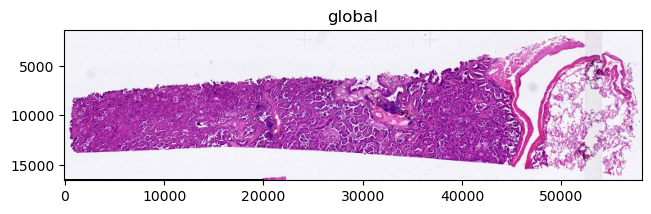

In [4]:
print(
    f"Data has {sdata_xenium.points['transcripts'].compute().shape[0]} transcript locations."
)
sdata_xenium.pl.render_images("he_image").pl.show()

Crop has 2683201 transcript locations.


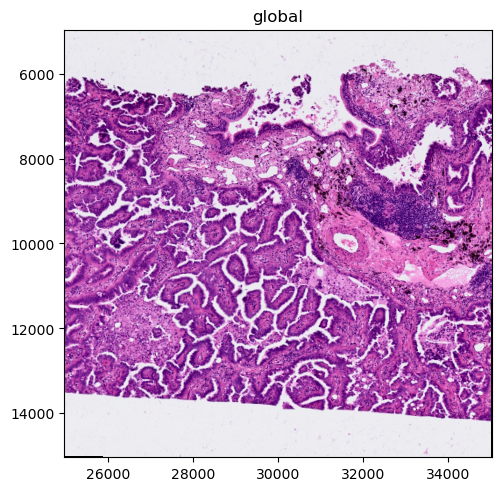

In [5]:
sdata_crop = sdata_xenium.query.bounding_box(
    axes=["x", "y"],
    min_coordinate=[25000, 5000],
    max_coordinate=[35000, 15000],
    target_coordinate_system="global",
)
print(
    f"Crop has {sdata_crop.points['transcripts'].compute().shape[0]} transcript locations."
)
sdata_crop.pl.render_images("he_image").pl.show()

In [6]:
sdata_crop.tables["table"]

AnnData object with n_obs × n_vars = 33727 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [7]:
sc.pp.normalize_total(sdata_crop.tables["table"], inplace=True)
sc.pp.log1p(sdata_crop.tables["table"])
sc.pp.pca(sdata_crop.tables["table"])
sc.pp.neighbors(sdata_crop.tables["table"])
sc.tl.umap(sdata_crop.tables["table"])
sc.tl.leiden(sdata_crop.tables["table"])

/Users/ttreis/miniforge3/envs/spatialdata-workshop/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
/var/folders/vk/6r7qz1g151xgg2tc9r84ym1m0000gp/T/ipykernel_31256/3929988892.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(sdata_crop.tables["table"])


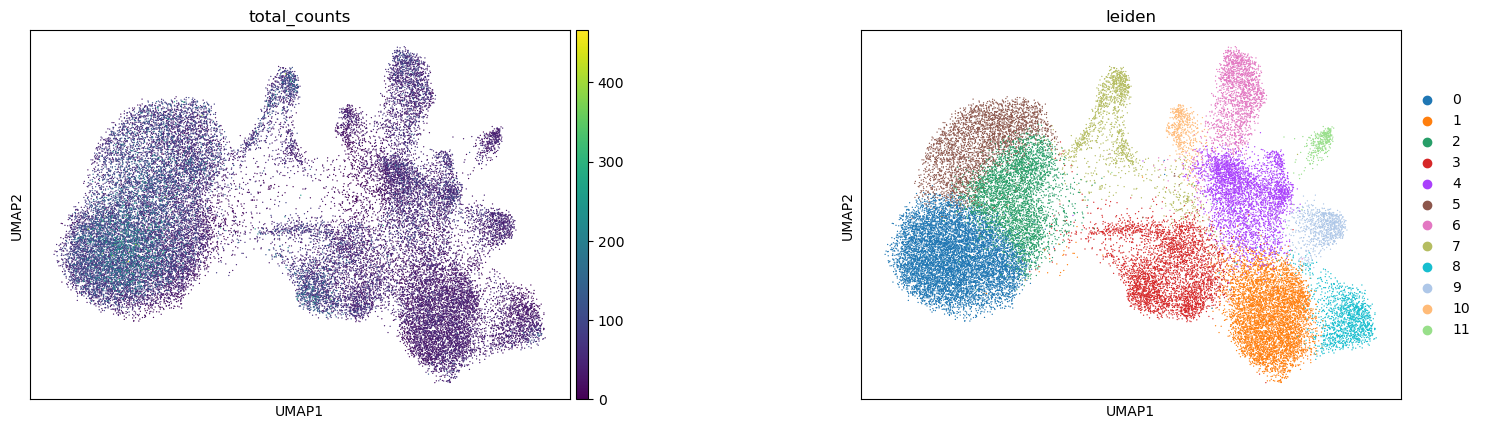

In [8]:
sc.pl.umap(
    sdata_crop.tables["table"],
    color=[
        "total_counts",
        "leiden",
    ],
    wspace=0.4,
)

## Investigate the proposed Leiden clusters
The Leiden clustering essentially clusters the data into an arbitrary amount of clusters based on similarity of the contained `AnnData` table. At this stage, it is recommended to directly use prior bio knowledge to annotate these clusters. We will do this in a fairly basic manner here, using marker genes for lung tissue from https://cellxgene.cziscience.com/gene-expression. 

In [18]:
HLCA_cell_type_signatures = {
    "alveolar_type1_fibroblasts": [
        "ADH1B",
        "DCN",
        "LUM",
        "FBLN1",
        "A2M",
        "C1S",
        "SCN7A",
        "C7_ENSG00000112936",
        "GPC3",
        "CFD",
        "FMO2",
        "GPX3",
        "RARRES2",
        "C1R",
        "PLEKHH2",
        "FBLN5",
        "FN1",
        "PRELP",
        "SELENOP",
        "SERPING1",
        "FHL1",
        "NBL1",
        "SLIT2",
        "MFAP4",
        "COL6A2",
    ],
    "alveolar_type2_fibroblast": [
        "DCN",
        "FBLN1",
        "C1S",
        "IGFBP6",
        "ADH1B",
        "CFD",
        "LUM",
        "C1R",
        "CCDC80",
        "C3_ENSG00000125730",
        "SFRP2",
        "COL6A2",
        "NNMT",
        "MGP",
        "EFEMP1",
        "FBN1",
        "GSN",
        "FSTL1",
        "PLAC9",
        "C7_ENSG00000112936",
        "ABI3BP",
        "SERPING1",
        "COL1A2",
        "MFAP5",
        "RARRES1",
    ],
    "endothelial_cell": [
        "CLDN5",
        "PECAM1",
        "EPAS1",
        "EGFL7",
        "RAMP2",
        "CALCRL",
        "GNG11",
        "VWF",
        "AQP1",
        "HYAL2",
        "TM4SF1",
        "ENG",
        "CLEC14A",
        "CAVIN2",
        "CDH5",
        "PTPRB",
        "RAMP3",
        "TFPI",
        "ARHGAP29",
        "CD93",
        "SLCO2A1",
        "SPARCL1",
        "LDB2",
        "CAV1",
        "PCAT19",
    ],
    "alveolar_macrophage": [
        "C1QA",
        "APOC1",
        "C1QB",
        "ACP5",
        "MARCO",
        "C1QC",
        "GRN",
        "CTSS",
        "FABP4",
        "FBP1",
        "PSAP",
        "FTL",
        "MS4A7",
        "MRC1",
        "MCEMP1",
        "CD68",
        "VSIG4",
        "MSR1",
        "OLR1",
        "APOE",
        "CTSD",
        "ALOX5AP",
        "CTSC",
        "GPNMB",
        "CAPG",
    ],
    "lung_interstitial_macrophage": [
        "C1QB",
        "C1QA",
        "C1QC",
        "CTSS",
        "CD68",
        "CD14",
        "CTSZ",
        "MS4A7",
        "CTSD",
        "PSAP",
        "IFI30",
        "CD163",
        "MS4A6A",
        "GRN",
        "MRC1",
        "APOE",
        "CYBB",
        "MS4A4A",
        "NPC2",
        "VSIG4",
        "FCGR3A",
        "FTL",
        "CTSC",
        "TYMP",
        "GPNMB",
    ],
    "fibroblast": [
        "DCN",
        "LUM",
        "FBLN1",
        "COL6A2",
        "COL1A2",
        "ADH1B",
        "COL6A3",
        "C1S",
        "C7_ENSG00000112936",
        "COL6A1",
        "C1R",
        "FN1",
        "MFAP4",
        "GPC3",
        "COL3A1",
        "CDH11",
        "RARRES2",
        "PCOLCE",
        "COL1A1",
        "NBL1",
        "TCF21",
        "OLFML3",
        "CALD1",
        "CFD",
        "COL5A2",
    ],
    "smooth_muscle_cell": [
        "ACTA2",
        "TAGLN",
        "TPM2",
        "MYL9",
        "CALD1",
        "MYH11",
        "IGFBP7",
        "TPM1",
        "SPARCL1",
        "C11orf96",
        "PPP1R14A",
        "SELENOM",
        "DSTN",
        "MYLK",
        "ACTG2",
        "ADIRF",
        "BGN",
        "SOD3",
        "MFGE8",
        "COL6A2",
        "LMOD1",
        "TINAGL1",
        "CAVIN3",
        "DES",
        "CNN1",
    ],
    "mast_cell": [
        "CPA3",
        "TPSAB1",
        "TPSB2",
        "HPGDS",
        "MS4A2",
        "KIT",
        "GATA2",
        "VWA5A",
        "SLC18A2",
        "IL1RL1",
        "HPGD",
        "RGS13",
        "SAMSN1",
        "RHEX",
        "RGS1",
        "HDC",
        "AREG",
        "LTC4S",
        "FOSB",
        "PTGS1",
        "CAPG",
        "CD69",
        "ARHGEF6",
        "PTGS2",
        "CD44",
    ],
    "dendritic_cell": [
        "HLA-DQB1",
        "CD74",
        "GPR183",
        "MS4A6A",
        "HLA-DPB1",
        "HLA-DRB5",
        "HLA-DQA1",
        "HLA-DPA1",
        "CLEC10A",
        "CD83",
        "CST3",
        "CPVL",
        "HLA-DMA",
        "FGL2",
        "CD1C",
        "CD86",
        "RNASE6",
        "FCER1A",
        "CSF2RA",
        "TYMP",
        "RGS1",
        "RGS10",
        "C1orf162",
        "GRN",
        "AREG",
    ],
}

It is expected that we find only a subset of these genes since Xenium itself only profiles a small portion of the entire transcriptome.

In [20]:
def find_signature_markers(signatures, data_columns):
    found_markers = {}
    for cell_type, genes in signatures.items():
        found_markers[cell_type] = [gene for gene in genes if gene in data_columns]
        print(
            f"Found {len(found_markers[cell_type])} genes of the {cell_type} signature: {found_markers[cell_type]}"
        )
    return found_markers


found_markers = find_signature_markers(
    HLCA_cell_type_signatures, sdata_crop.tables["table"].to_df().columns
)

Found 2 genes of the alveolar_type1_fibroblasts signature: ['FBLN1', 'GPC3']
Found 5 genes of the alveolar_type2_fibroblast signature: ['FBLN1', 'SFRP2', 'FBN1', 'PLAC9', 'MFAP5']
Found 10 genes of the endothelial_cell signature: ['PECAM1', 'EGFL7', 'RAMP2', 'GNG11', 'VWF', 'CLEC14A', 'CAVIN2', 'TFPI', 'CD93', 'CAV1']
Found 5 genes of the alveolar_macrophage signature: ['MARCO', 'MRC1', 'MCEMP1', 'CD68', 'VSIG4']
Found 8 genes of the lung_interstitial_macrophage signature: ['CD68', 'CD14', 'CD163', 'MS4A6A', 'MRC1', 'MS4A4A', 'VSIG4', 'FCGR3A']
Found 4 genes of the fibroblast signature: ['FBLN1', 'GPC3', 'PCOLCE', 'COL5A2']
Found 6 genes of the smooth_muscle_cell signature: ['ACTA2', 'MYH11', 'MYLK', 'ACTG2', 'DES', 'CNN1']
Found 9 genes of the mast_cell signature: ['CPA3', 'HPGDS', 'MS4A2', 'KIT', 'GATA2', 'VWA5A', 'SLC18A2', 'IL1RL1', 'CD69']
Found 10 genes of the dendritic_cell signature: ['GPR183', 'MS4A6A', 'CLEC10A', 'CD83', 'FGL2', 'CD1C', 'CD86', 'FCER1A', 'CSF2RA', 'C1orf162']

In [26]:
def rank_and_normalize_gexp(series):
    ranked = series.rank(ascending=False, method="min")
    min_rank = ranked.min()
    max_rank = ranked.max()

    return ranked.apply(lambda x: (x - min_rank) / (max_rank - min_rank))


def make_score_from_signature(adata, signature, zero_as_none=True):

    return (
        adata.to_df()[signature]
        .rank(ascending=False, method="min")  # Sort genes by rank, ties = equal rank
        .apply(
            lambda col: rank_and_normalize_gexp(col)
        )  # Normalize the ranks to [0, 1]
        .sum(axis=1)  # Sum the normalized ranks
        .apply(lambda row: None if zero_as_none and row == 0 else row)
    )


def compute_signature_scores(adata, found_markers):
    for cell_type, markers in found_markers.items():
        adata.obs[cell_type + "_score"] = make_score_from_signature(adata, markers)
    score_colnames = [cell_type + "_score" for cell_type in found_markers.keys()]
    return score_colnames


score_colnames = compute_signature_scores(sdata_crop.tables["table"], found_markers)

sdata_crop.tables["table"].obs[score_colnames]

alveolar_type1_fibroblasts_score  alveolar_type2_fibroblast_score  \
22691                                NaN                              NaN   
22692                           0.929370                         1.851537   
22693                           0.935953                         0.935953   
22694                           0.929370                         0.929370   
22695                                NaN                              NaN   
...                                  ...                              ...   
162118                               NaN                              NaN   
162119                               NaN                              NaN   
162120                               NaN                              NaN   
162121                               NaN                         0.999970   
162122                               NaN                              NaN   

        endothelial_cell_score  alveolar_macrophage_score  \
22691                      NaN                        NaN   
22692                      NaN                        NaN   
22693                 0.877780                        NaN   
22694                 0.954664                        NaN   
22695                 0.950543                        NaN   
...                        ...                        ...   
162118                0.988318                        NaN   
162119                0.960209                        NaN   
162120                0.772520                   0.956918   
162121                     NaN                   0.999644   
162122                0.996709                        NaN   

        lung_interstitial_macrophage_score  fibroblast_score  \
22691                                  NaN               NaN   
22692                             0.930111          0.929370   
22693                                  NaN          0.935953   
22694                             0.867665          0.929370   
22695                                  NaN               NaN   
...                                    ...               ...   
162118                            1.995463               NaN   
162119                                 NaN               NaN   
162120                            1.878133               NaN   
162121                            0.999644               NaN   
162122                                 NaN               NaN   

        smooth_muscle_cell_score  mast_cell_score  dendritic_cell_score  
22691                        NaN              NaN              0.951225  
22692                        NaN         0.987280                   NaN  
22693                   0.922844         0.970498              1.909476  
22694                        NaN              NaN              0.867665  
22695                        NaN              NaN              0.969193  
...                          ...              ...                   ...  
162118                       NaN              NaN              0.999318  
162119                       NaN         0.991905                   NaN  
162120                  0.965633              NaN              0.921216  
162121                       NaN              NaN                   NaN  
162122                       NaN              NaN                   NaN  

[33727 rows x 9 columns]

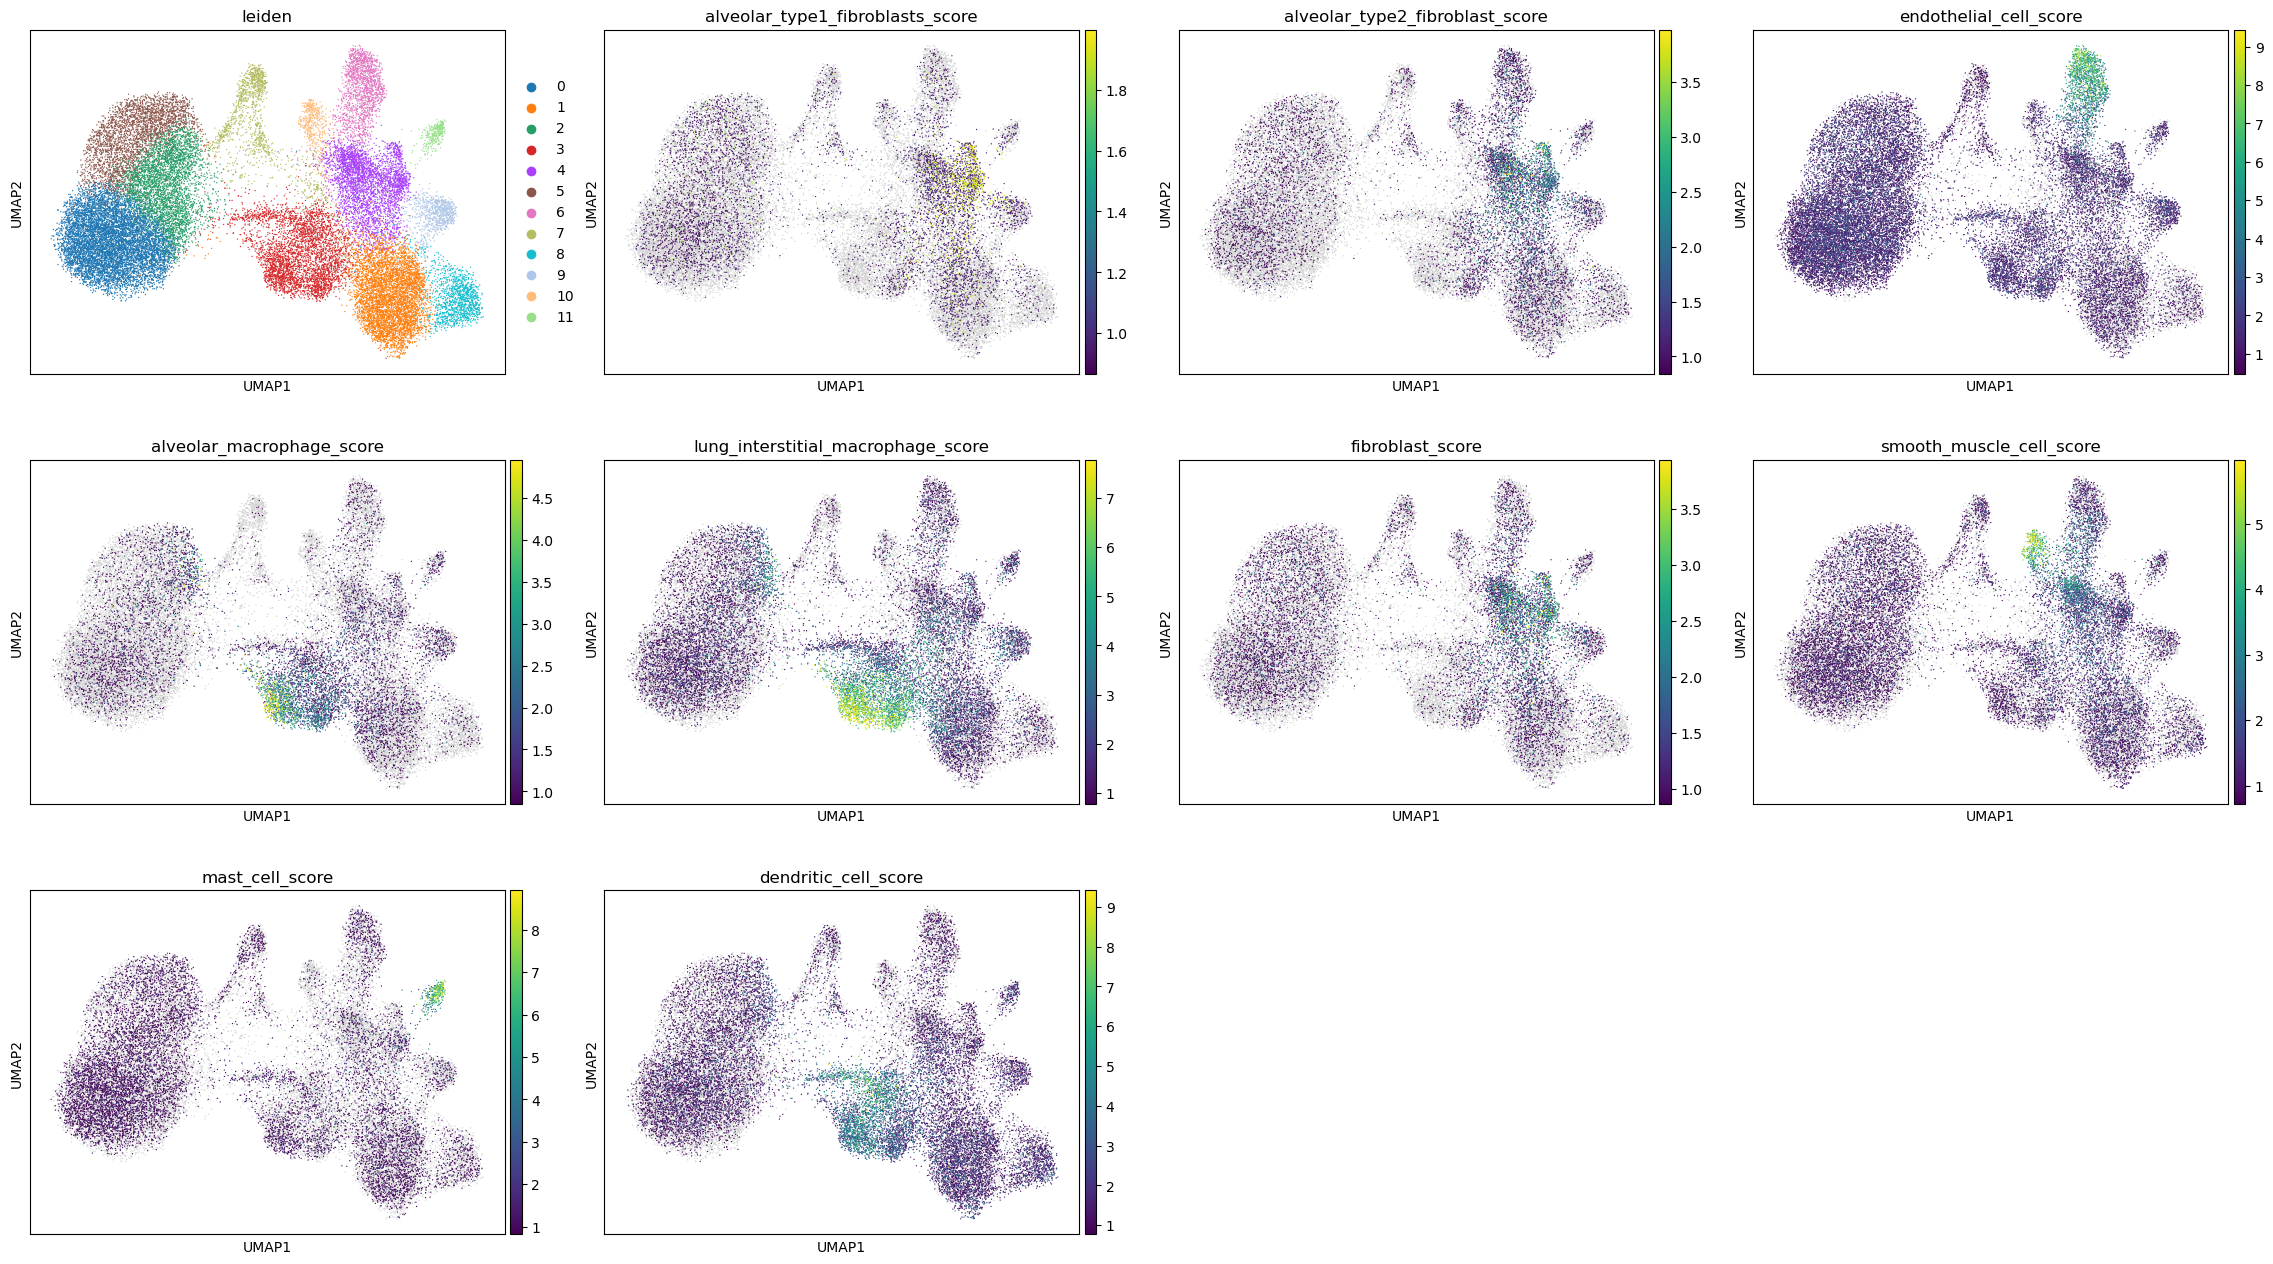

In [40]:
sc.pl.umap(
    sdata_crop.tables["table"],
    color=["leiden"] + score_colnames,
    wspace=0.1,
)

While we were able to identify some of the celltypes represented by the clusters, in particular fibroblasts, endothelial cells, muscle cells and mast cells, some clusters were either not amongst these cell types or were grouped into the same cluster, for example the dendritic cells and macrophages which form leiden cluster #3. We can already appreciate the following mapping:

- Cluster 0: ???
- Cluster 1: Smooth muscle cells
- Cluster 2: ???
- Cluster 3: Macrophages & Dendritic cells
- Cluster 4: Fibroblasts
- Cluster 5: ???
- Cluster 6: Endothelial cells
- Cluster 7: ???
- Cluster 8: ???
- Cluster 9: ???
- Cluster 10: ???
- Cluster 11: Mast cells


Since the clusters 0, 2, and 5, represent a large portion of our cells, we'll try to identify these cells by more closely looking into their expression values.

In [44]:
adata_025 = sdata_crop.tables["table"][
    sdata_crop.tables["table"].obs["leiden"].isin(["0", "2", "5"])
]
adata_025

View of AnnData object with n_obs × n_vars = 15186 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'leiden', 'alveolar_macrophage_signature_score', 'alveolar_epitheleal_cells_signature_score', 'alveolar_type1_fibroblasts_score', 'alveolar_type2_fibroblast_score', 'endothelial_cell_score', 'alveolar_macrophage_score', 'lung_interstitial_macrophage_score', 'fibroblast_score', 'smooth_muscle_cell_score', 'mast_cell_score', 'dendritic_cell_score'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/ttreis/miniforge3/envs/spatialdata-workshop/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


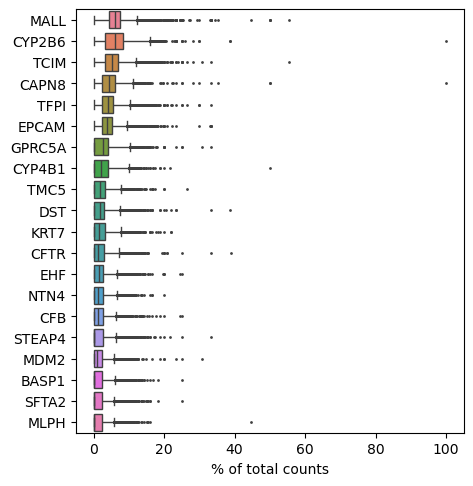

In [45]:
sc.pl.highest_expr_genes(adata_025, n_top=20)

We can extract these genes and then use the HLCA explorer by CELLxGENE to try to find out which cells the clusters could be. For this, we'll paste the "signature" into their GUI.


> MALL, CYP2B6, TCIM, CAPN8, TFPI, EPCAM, GPRC5A, CYP4B1, TMC5, DST, KRT7, CFTR, EHF, NTN4, CFB, STEAP4, MDM2, BASP1, SFTA2, MLPH

From there we can extract several cell types which highly express these genes:

![image.png](./nb4_cellxgene.png)

We hand-picked a few of the signatures and will repeat the above steps:

In [47]:
proposed_celltype_signatures = {
    "pneumocyte": [
        "SFTPB",
        "NAPSA",
        "SFTPA1",
        "SLC34A2",
        "SFTPA2",
        "SFTPC",
        "SFTPD",
        "PEBP4",
        "CTSH",
        "HOPX",
        "SFTA3_ENSG00000229415",
        "LAMP3",
        "ABCA3",
        "PGC",
        "SLC39A8",
        "CLDN18",
        "MUC1",
        "C4BPA",
        "DHCR24",
        "SDR16C5",
        "WIF1",
        "C16orf89",
        "SDC4",
        "SFTA2",
        "ATP11A",
    ],
    "club_cell": [
        "PIGR",
        "CXCL17",
        "SCGB3A1",
        "SCGB1A1",
        "SFTPB",
        "SLPI",
        "WFDC2",
        "BPIFB1",
        "CP",
        "CEACAM6",
        "C16orf89",
        "KLK11",
        "SCGB3A2",
        "CYP4B1",
        "CYP2F1",
        "LCN2",
        "AGR3",
        "STEAP4",
        "NEDD4L",
    ],
    "basal_cell": [
        "S100A2",
        "KRT17",
        "AQP3",
        "KRT5",
        "KRT15",
        "TACSTD2",
        "KRT19",
        "F3_ENSG00000117525",
        "SERPINB3",
        "ALDH3A1",
        "CLDN1",
        "CXCL1",
        "MIR205HG",
    ],
}

Found 3 genes of the pneumocyte signature: ['PEBP4', 'LAMP3', 'SFTA2']
Found 5 genes of the club_cell signature: ['KLK11', 'CYP4B1', 'CYP2F1', 'AGR3', 'STEAP4']
Found 2 genes of the basal_cell signature: ['AQP3', 'SERPINB3']


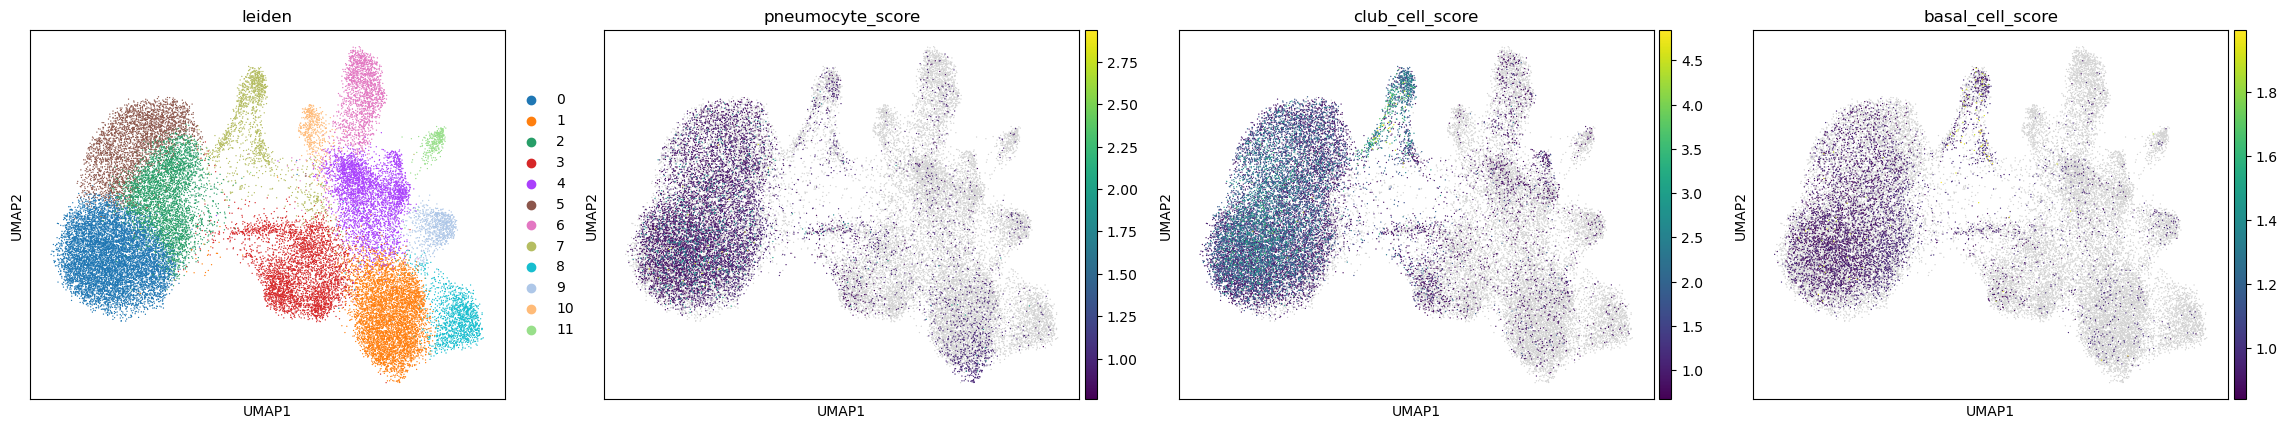

In [50]:
found_markers_in_unknown_cluster = find_signature_markers(
    proposed_celltype_signatures, sdata_crop.tables["table"].to_df().columns
)

additional_score_colnames = compute_signature_scores(
    sdata_crop.tables["table"], found_markers_in_unknown_cluster
)

sc.pl.umap(
    sdata_crop.tables["table"],
    color=["leiden"] + additional_score_colnames,
    wspace=0.1,
)

While these plots might suggest that the 3 proposed cell-types are somewhere in there, we can also see that only very few genes of those signatures are used for every annotation. This can be attributed to the limited size of the Xenium panel. One possible step to better analse these cells is to subcluster and reanalyse them. Within the scope of this tutorial, we will however not proceed with this due to time limitations. Instead, we will assume that Leiden cluster 7 represents the Club cells and label clusters 0, 2, and 5 as "Pneumocytes / Basal Cells"

### Rename clusters
Based on our bio-investigation of our Leiden clusters, we can now use this information to localise them in the tissue.

In [80]:
celltype_mapping = {
    "0": "Pneumocytes / Basal Cells",
    "1": "Smooth muscle cells",
    "2": "Pneumocytes / Basal Cells",
    "3": "Macrophages & Dendritic cells",
    "4": "Fibroblasts",
    "5": "Pneumocytes / Basal Cells",
    "6": "Endothelial cells",
    "7": "Club cells",
    "11": "Mast cells",
}


sdata_crop.tables["table"].obs["celltype"] = (
    sdata_crop.tables["table"].obs["leiden"].map(celltype_mapping)
)
sdata_crop.tables["table"].obs["celltype"].fillna("Unknown", inplace=True)

sdata_crop.tables["table"].obs["celltype"] = pd.Categorical(
    sdata_crop.tables["table"].obs["celltype"]
)

/var/folders/vk/6r7qz1g151xgg2tc9r84ym1m0000gp/T/ipykernel_31256/1239269867.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sdata_crop.tables["table"].obs["celltype"].fillna("Unknown", inplace=True)


/Users/ttreis/miniforge3/envs/spatialdata-workshop/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


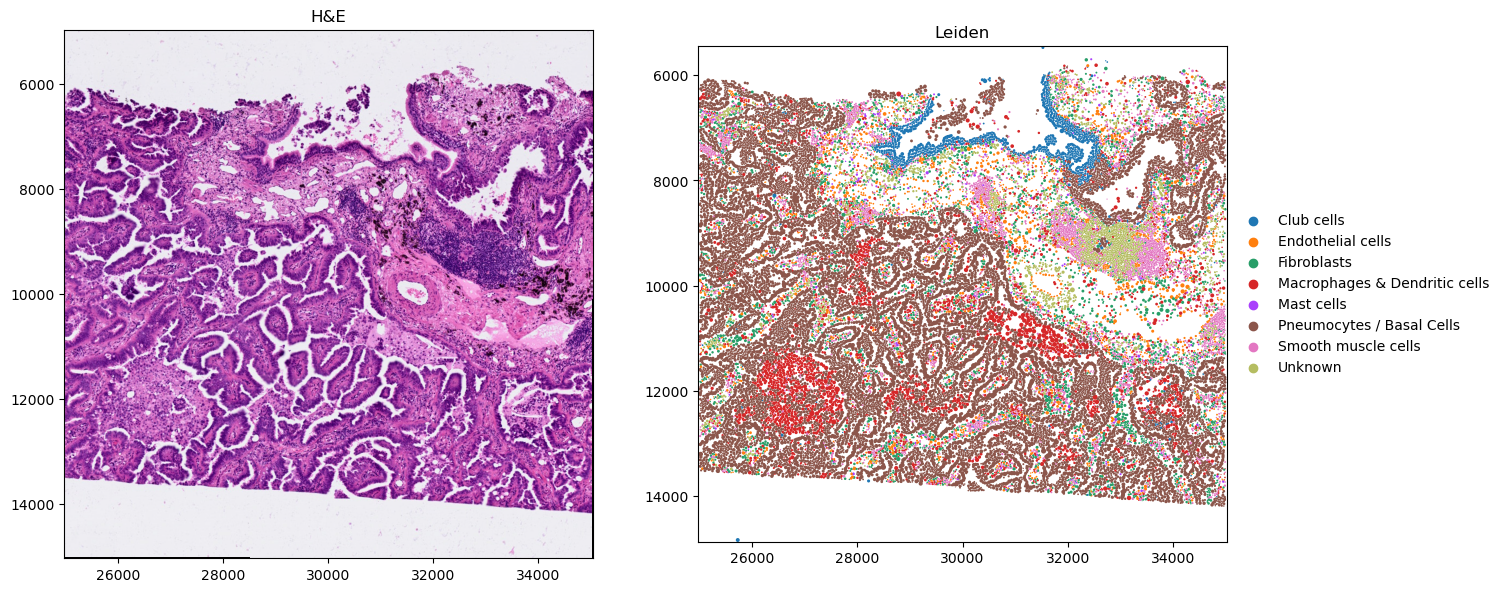

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))

sdata_crop.pl.render_images("he_image").pl.show(ax=axs[0], title="H&E")

sdata_crop.pl.render_shapes(
    "cell_circles",
    color="celltype",
    method="matplotlib",
).pl.show(ax=axs[1], title="Leiden")

We can also try to overlay these plots.

/Users/ttreis/miniforge3/envs/spatialdata-workshop/lib/python3.11/site-packages/spatialdata_plot/pl/utils.py:782: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_mapping)


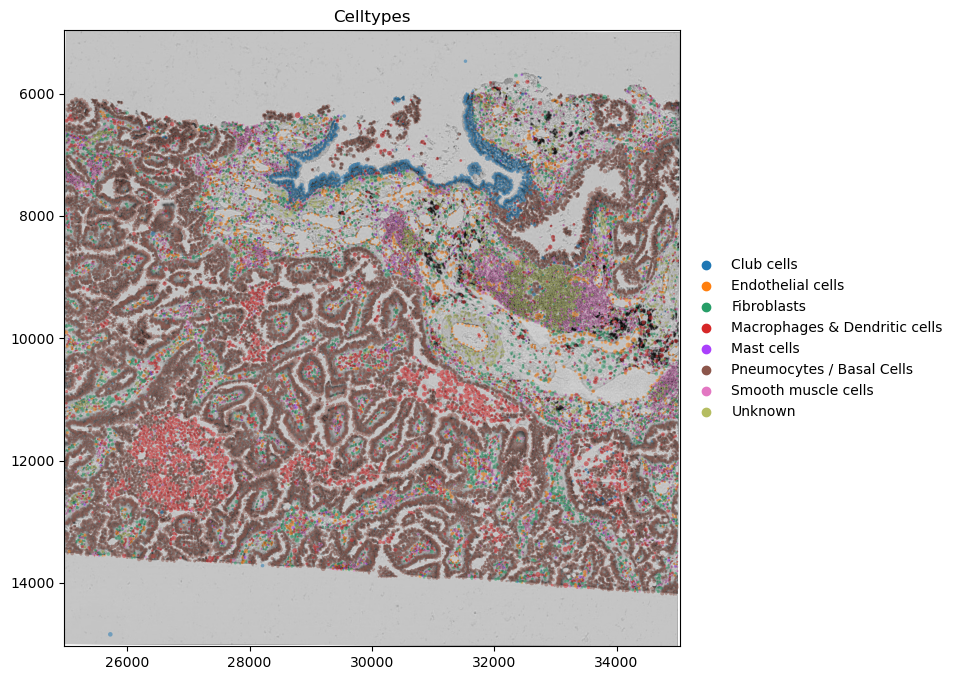

In [117]:
fig, axs = plt.subplots(1, 1, figsize=(15, 8))

sdata_crop.pl.render_images(
    "he_image",
    # cmap="Greys",  # since the cmap argument currently has a bug with multiscale images, we'll use a simple grey colorscale
    channel=0,
    palette="lightgrey",
).pl.render_shapes(
    "cell_circles",
    color="celltype",
    fill_alpha=0.5,
    method="matplotlib",
).pl.show(
    ax=axs, title="Celltypes", colorbar=False
)